# グラフで2バイト文字を使うためのライブラリのインストール

In [1]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=a5f814c58b4e4fa87f8eb026dafa7a8250431be828bf72ea86ddf7e15ebab4bc
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


# 乱数シードの固定

In [2]:
import random
import numpy as np
import os

np.random.seed(0)
random.seed(0)
os.environ["PYTHONHASHSEED"] = str(0)

# 関数 save_fig：図の保存用

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def save_fig(plt, file_prefix):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches = 0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches = 0.2)

# 関数 show_prediction：予測結果の可視化

In [4]:
def show_prediction(x, y_true, y_pred, ids, dataset='mnist', labels=None, file_prefix=''):
    '''認識結果を可視化する。
    Args:
        x (ndarray): 画像。形状は(B, N)。Bは画像枚数、Nは1枚の画像の画素数
        y_true (ndarray): 正解クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        y_pred (ndarray): 予測クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        ids (ndarray): 表示する画像のインデックスを格納した配列
        dataset (str): データセット名
        labels (list): クラスラベル名が格納されたリスト
        file_prefix (str): 可視化結果を保存する際のファイル名接頭辞
    '''

    def _mnist():
        """MNIST用可視化関数"""
        img = x[ids].reshape((len(ids), 28, 28))

        labels = y_true[ids]
        preds = y_pred[ids]

        # AIが認識した結果を画像と一緒に提示する
        plt.figure(2, figsize=(12, 8))
        plt.gray()
        for i in range(len(ids)):
            plt.subplot(8, 12, i + 1)
            plt.pcolor(img[i])
            plt.text(22, 25.5, "%d" % preds[i], fontsize=12, color='yellow')
            if preds[i] != labels[i]:
                plt.plot([0, 27], [1, 1], color='red', linewidth=5)

            plt.xlim(0, 27)
            plt.ylim(27, 0)
            plt.xticks([], '')
            plt.yticks([], '')

        plt.tight_layout()
        save_fig(plt, file_prefix=file_prefix)
        plt.show()

    def _cifar10():
        """CIFAR-10用可視化関数"""
        img = x[ids].reshape((len(ids), 32, 32, 3))

        trues = y_true[ids]
        preds = y_pred[ids]

        # AIが認識した結果を画像と一緒に提示する
        plt.figure(figsize=(24, 16))
        for i in range(len(ids)):
            plt.subplot(8, 12, i + 1)
            plt.imshow(img[i])

            p = preds[i]
            t = trues[i]
            if p != t:
                plt.title(f'{labels[t]}({labels[p]})', color='red', fontsize=12)
            else:
                plt.title(f'{labels[t]}', fontsize=12)

            plt.axis('off')

        plt.tight_layout()
        save_fig(plt, file_prefix=file_prefix)
        plt.show()

    if dataset == 'mnist':
        _mnist()
    else:
        _cifar10()

# 関数 evaluate：性能評価関数

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

def evaluate(x, y_true, y_pred, file_prefix=''):
    """予測結果に対する性能評価を行う。正解率、精度、再現率の計算。混同行列をヒートマップとして可視化。
    Args:
        x (ndarray): 画像。形状は(B, N)。Bは画像枚数、Nは1枚の画像の画素数
        y_true (ndarray): 正解クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        y_pred (ndarray): 予測クラスラベル。形状は(B, C)。Bは画像枚数、Cはクラス数
        file_prefix (str): 可視化結果を保存する際のファイル名接頭辞
    """
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    print('正解率')
    print(f' {accuracy:.2f}')

    class_labels = []

    num_classes = np.max(y_true) + 1
    for i in range(num_classes):
        class_labels.append(f'{i:4d}')

    precision_str = []
    recall_str = []
    for i in range(num_classes):
        precision_str.append(f'{precision[i]:.2f}')
        recall_str.append(f'{recall[i]:.2f}')

    print('精度')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(precision_str))

    print('再現率')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(recall_str))

    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, fmt='3d', square=True, cmap='hot')
    plt.tight_layout()
    save_fig(plt, file_prefix=file_prefix)
    plt.show()

# 関数 show_history：学習過程の可視化

In [6]:
def show_history(history, file_prefix=''):
    """学習過程（損失と正解率）を可視化する
    Args:
        history (tf.keras.callbacks.History): 損失やモニターする指標を格納したオブジェクト
    """
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(wspace=0.2)

    # 学習曲線の表示
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'black', label='Training')
    plt.plot(history.history['val_loss'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
    plt.title('損失', fontsize=16)
    plt.ylim(0, )
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

    # 正解率表示
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'black', label='Training')
    plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
    plt.title('正解率', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 1.2)
    plt.grid(True)

    save_fig(plt, file_prefix)

    plt.show()

# 実習10.1：MNISTデータセットの準備

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# チャネル数(グレースケール画像はチャネル数1)
nc=1

# 訓練データの準備
print('訓練データ')
print('画像枚数:', len(x_train))

# 先頭の画像を取り出して、形状を取得
ny, nx = x_train[0].shape
print('画像の縦方向画素数:', ny)
print('画像の横方向画素数:', nx)

# 訓練データの形状は(枚数, 高さ, 幅)から(枚数, 高さ, 幅, チャネル数)へ変形
x_train = x_train.reshape(-1, ny , nx, nc)
print('画像の形状:', x_train.shape)
x_train = x_train.astype('float32') # 要素値の型をfloat32へ変更
# 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
x_train = x_train / 255

# クラス数。0から9の数字なので10クラス
num_classes=np.max(y_train)+1
print('クラス数:', num_classes)

# クラスラベルをone-hotベクトル化
y_train = to_categorical(y_train, num_classes)
print('クラスラベルの形状:', y_train.shape)

#　テストデータの準備
print("\nテストデータ")
print('画像枚数:', len(x_test))

# テストデータの形状を(枚数, 高さ, 幅)から
# (枚数, 高さ, 幅, チャネル数)へ変形
x_test = x_test.reshape(-1, ny , nx, nc)
print('画像の形状:', x_test.shape)
x_test = x_test.astype('float32') # 要素値の型をfloat32へ変更
# 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
x_test = x_test / 255

# クラスラベルをone-hotベクトル化
y_test = to_categorical(y_test, num_classes)
print('クラスラベルの形状:', y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
訓練データ
画像枚数: 60000
画像の縦方向画素数: 28
画像の横方向画素数: 28
画像の形状: (60000, 28, 28, 1)
クラス数: 10
クラスラベルの形状: (60000, 10)

テストデータ
画像枚数: 10000
画像の形状: (10000, 28, 28, 1)
クラスラベルの形状: (10000, 10)


# 実習10.2：MNIST用の畳み込みニューラルネットワークの定義

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

# 縦、横方向画素数、チャネル数を1枚目の画像から取得
ny,nx,nc = x_train[0].shape

# ネットワークのパラメータ（重みとバイアス）を初期化する際の乱数シードを固定
tf.random.set_seed(0)

# ネットワークモデルを生成。層（レイヤー）の容器と考える。
model1=Sequential()

# 畳み込み層を追加
# 1番目の中間層（畳み込み層）では、入力層の形状を指定する必要がある。
model1.add(Conv2D(input_shape=(ny,nx,nc),   # 入力層の形状
                  filters=16,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 2番目の中間層:畳み込み層
model1.add(Conv2D(filters=32,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 3番目の中間層:マックスプーリング層。次回授業で解説。
model1.add(MaxPooling2D(pool_size=(2,2)))   # プールサイズ(縦、横)

# 4番目の中間層:畳み込み層
model1.add(Conv2D(filters=64,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 5番目の中間層:マックスプーリング層。次回授業で解説。
model1.add(MaxPooling2D(pool_size=(2,2)))   # プールサイズ(縦、横)

# 特徴マップを全結合層への入力(1次元配列)とするため形状を変形
# (5, 5, 64) -> (5 * 5 * 64)
model1.add(Flatten())

# これ以降は分類用の全結合型ニューラルネットワーク
# 6番目の中間層:全結合層
model1.add(Dense(units=128,          # ニューロン数
                 activation='relu')) # 活性化関数ReLU

# 出力層:全結合層
model1.add(Dense(units=num_classes,     # ニューロン数
                 activation='softmax')) # 活性化関数ソフトマックス関数


model1.compile(optimizer='SGD',                 # パラメータの最適化手法にAdamを指定
               loss='categorical_crossentropy', # 損失関数
               metrics=['accuracy'])            # 損失の他にモニターする指標として正解率を指定

# モデルの要約情報を表示
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0

# 実習10.3：MNIST用ネットワークの学習

In [9]:
# 学習開始。終了後、学習の履歴がhistory1に代入される
history1=model1.fit(x_train, # 訓練データ：入力画像
                    y_train, # 訓練データ：クラスラベル
                    epochs=50, # エポック数
                    batch_size=1000, # バッチサイズ
                    shuffle=True,    # 学習時にデータの並びをシャッフル
                    validation_data=(x_test,y_test)) # 学習過程での汎化能力の推定のためテストデータを指定

Epoch 1/50
60/60 [==============================] - 17s 27ms/step - loss: 2.2494 - accuracy: 0.2120 - val_loss: 2.1748 - val_accuracy: 0.3885
Epoch 2/50
60/60 [==============================] - 1s 23ms/step - loss: 1.9574 - accuracy: 0.5215 - val_loss: 1.4966 - val_accuracy: 0.6719
Epoch 3/50
60/60 [==============================] - 1s 23ms/step - loss: 0.9801 - accuracy: 0.7466 - val_loss: 0.6559 - val_accuracy: 0.7992
Epoch 4/50
60/60 [==============================] - 1s 23ms/step - loss: 0.5977 - accuracy: 0.8062 - val_loss: 0.5468 - val_accuracy: 0.8119
Epoch 5/50
60/60 [==============================] - 1s 23ms/step - loss: 0.4465 - accuracy: 0.8581 - val_loss: 0.4018 - val_accuracy: 0.8705
Epoch 6/50
60/60 [==============================] - 1s 24ms/step - loss: 0.3589 - accuracy: 0.8890 - val_loss: 0.3089 - val_accuracy: 0.9074
Epoch 7/50
60/60 [==============================] - 1s 25ms/step - loss: 0.3231 - accuracy: 0.9006 - val_loss: 0.2708 - val_accuracy: 0.9210
Epoch 8/50
6

# 実習10.4：MNIST用ネットワークの学習の履歴と汎化能力の推定

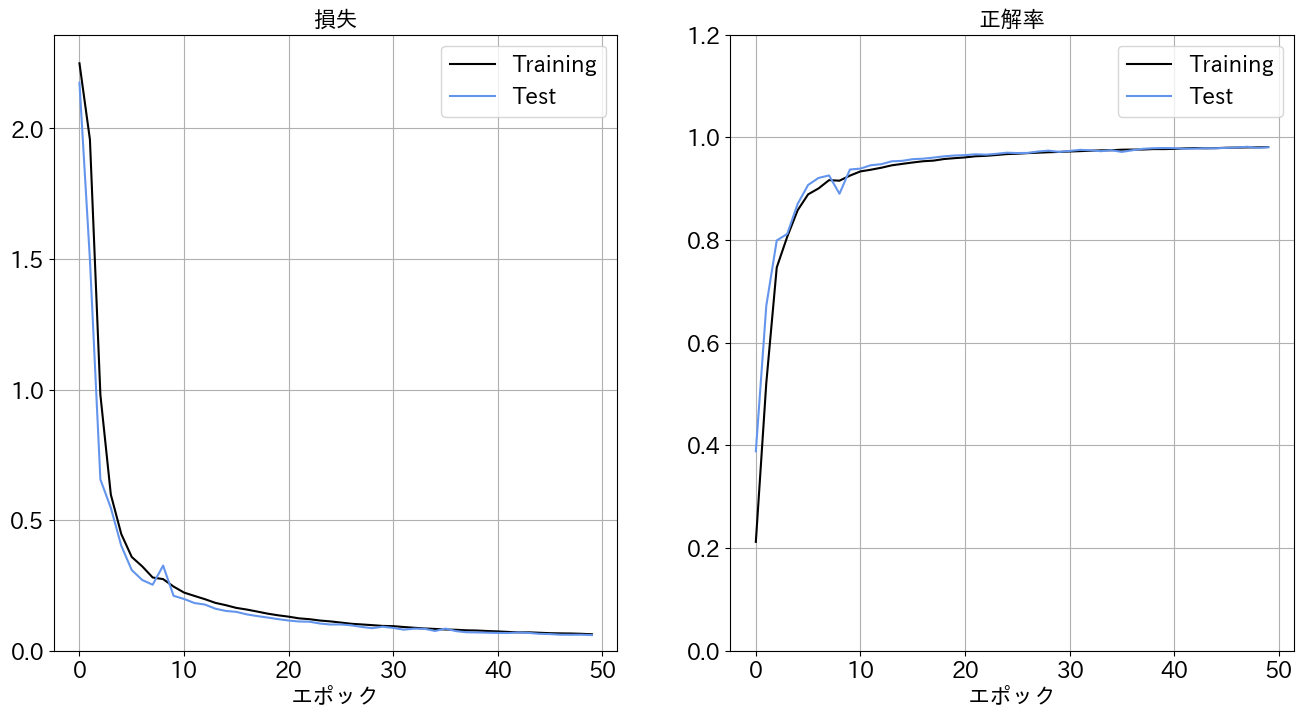

正解率
 0.98
精度
    0    1    2    3    4    5    6    7    8    9
 0.98 0.99 0.98 0.96 0.98 0.98 0.99 0.98 0.98 0.99
再現率
    0    1    2    3    4    5    6    7    8    9
 0.99 0.99 0.97 0.99 0.99 0.98 0.98 0.98 0.97 0.97


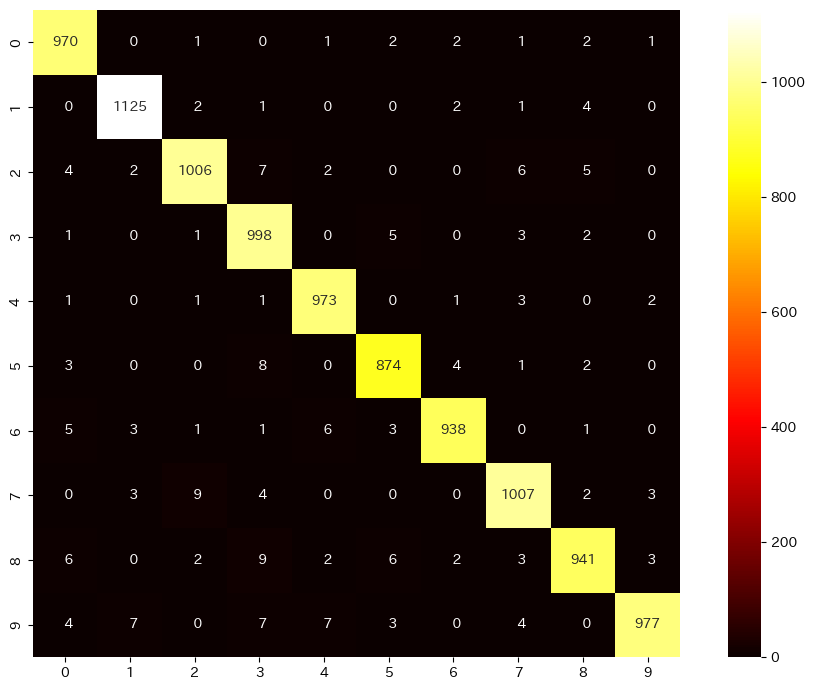

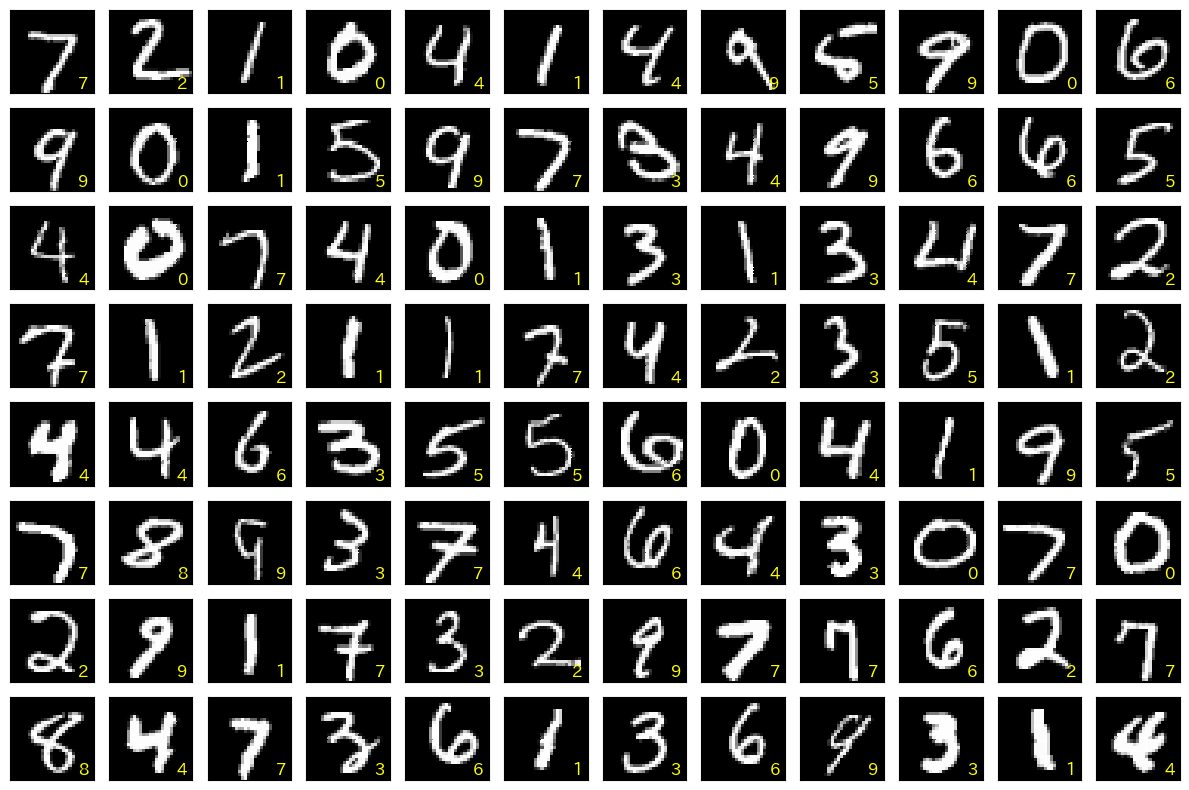

In [10]:
# 学習の履歴（損失と正解率の変化）を表示
show_history(history1)

# 学習したモデルを使い、テストデータのクラスラベルを予測
y_pred=model1.predict(x_test, verbose=0)

# 各データについて、最大の予測確率を持つクラスラベルを取得
y_pred=np.argmax(y_pred, axis=1)

# 正解（one-hotベクトル）をクラスラベルに戻す
y_true=np.argmax(y_test, axis=1)

# 混同行列、正解率、精度、再現率を評価
evaluate(x_test,y_true,y_pred)

# 予測結果の一部を可視化する
ids=range(96) # 可視化するデータの番号0から95

# データの番号0から95について、予測結果を可視化
show_prediction(x_test,y_true,y_pred,ids)

# 実習10.5：CIFAR-10データセットの準備

In [11]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

# ラベル名
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# これ以降にコードを記述する
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
ny,nx,nc=x_train[0].shape
print('画像の縦方向画素数：',ny)
print('画像の横方向画素数：',nx)
print('画像のチャネル数：',nc)

x_train = x_train.astype('float32') # 要素値の型をfloat32へ変更
# 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
x_train = x_train / 255

# クラス数。10クラス
num_classes=np.max(y_train)+1

# クラスラベルをone-hotベクトル化
y_train=to_categorical(y_train,num_classes)
print('訓練データのクラスラベル形状：', y_train.shape)

#　テストデータの準備
x_test = x_test.astype('float32') # 要素値の型をfloat32へ変更
# 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
x_test = x_test / 255

# クラスラベルをone-hotベクトル化
y_test = to_categorical(y_test, num_classes)
print('テストデータのクラスラベルの形状:', y_test.shape)

170498071/170498071 [==============================] - 4s 0us/step
画像の縦方向画素数： 32
画像の横方向画素数： 32
画像のチャネル数： 3
訓練データのクラスラベル形状： (50000, 10)
テストデータのクラスラベルの形状: (10000, 10)


# 実習10.6：CIFAR-10用の畳み込みニューラルネットワークの定義

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

# 縦、横方向画素数、チャネル数を1枚目の画像から取得
ny,nx,nc = x_train[0].shape

# ネットワークのパラメータ（重みとバイアス）を初期化する際の乱数シードを固定
tf.random.set_seed(0)

# ネットワークモデルを生成。層（レイヤー）の容器と考える。
model2=Sequential()

# 畳み込み層を追加
# 1番目の中間層（畳み込み層）では、入力層の形状を指定する必要がある。
model2.add(Conv2D(input_shape=(ny,nx,nc),   # 入力層の形状
                  filters=16,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 2番目の中間層:畳み込み層
model2.add(Conv2D(filters=32,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 3番目の中間層:マックスプーリング層。次回授業で解説。
model2.add(MaxPooling2D(pool_size=(2,2)))   # プールサイズ(縦、横)

# 4番目の中間層:畳み込み層
model2.add(Conv2D(filters=64,               # フィルタ数
                  kernel_size=(3,3),        # カーネルサイズ(縦、横)
                  activation='relu'))       # 活性化関数ReLU

# 5番目の中間層:マックスプーリング層。次回授業で解説。
model2.add(MaxPooling2D(pool_size=(2,2)))   # プールサイズ(縦、横)

# 特徴マップを全結合層への入力(1次元配列)とするため形状を変形
# (6, 6, 64) -> (6 * 6 * 64)
model2.add(Flatten())

# これ以降は分類用の全結合型ニューラルネットワーク
# 6番目の中間層:全結合層
model2.add(Dense(units=128,          # ニューロン数
                 activation='relu')) # 活性化関数ReLU

# 出力層:全結合層
model2.add(Dense(units=num_classes,     # ニューロン数
                 activation='softmax')) # 活性化関数ソフトマックス関数


model2.compile(optimizer='SGD',                 # パラメータの最適化手法にAdamを指定
               loss='categorical_crossentropy', # 損失関数
               metrics=['accuracy'])            # 損失の他にモニターする指標として正解率を指定

# モデルの要約情報を表示
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)             

# 実習10.7：CIFAR-10用の畳み込みニューラルネットワークの学習

In [13]:
# 学習開始。終了後、学習の履歴がhistory2に代入される
history2=model2.fit(x_train, # 訓練データ：入力画像
                    y_train, # 訓練データ：クラスラベル
                    epochs=500, # エポック数
                    batch_size=1000, # バッチサイズ
                    shuffle=True,    # 学習時にデータの並びをシャッフル
                    validation_data=(x_test,y_test)) # 学習過程での汎化能力の推定のためテストデータを指定

Epoch 1/500
50/50 [==============================] - 4s 44ms/step - loss: 2.3011 - accuracy: 0.1226 - val_loss: 2.2945 - val_accuracy: 0.1272
Epoch 2/500
50/50 [==============================] - 2s 34ms/step - loss: 2.2896 - accuracy: 0.1311 - val_loss: 2.2836 - val_accuracy: 0.1339
Epoch 3/500
50/50 [==============================] - 2s 35ms/step - loss: 2.2779 - accuracy: 0.1463 - val_loss: 2.2701 - val_accuracy: 0.1455
Epoch 4/500
50/50 [==============================] - 2s 35ms/step - loss: 2.2615 - accuracy: 0.1642 - val_loss: 2.2494 - val_accuracy: 0.1775
Epoch 5/500
50/50 [==============================] - 2s 36ms/step - loss: 2.2348 - accuracy: 0.1930 - val_loss: 2.2137 - val_accuracy: 0.2050
Epoch 6/500
50/50 [==============================] - 2s 37ms/step - loss: 2.1884 - accuracy: 0.2204 - val_loss: 2.1541 - val_accuracy: 0.2362
Epoch 7/500
50/50 [==============================] - 2s 34ms/step - loss: 2.1167 - accuracy: 0.2480 - val_loss: 2.0717 - val_accuracy: 0.2603
Epoch 

# 実習10.8：CIFAR-10用の畳み込みニューラルネットワークの学習の履歴と汎化能力の推定

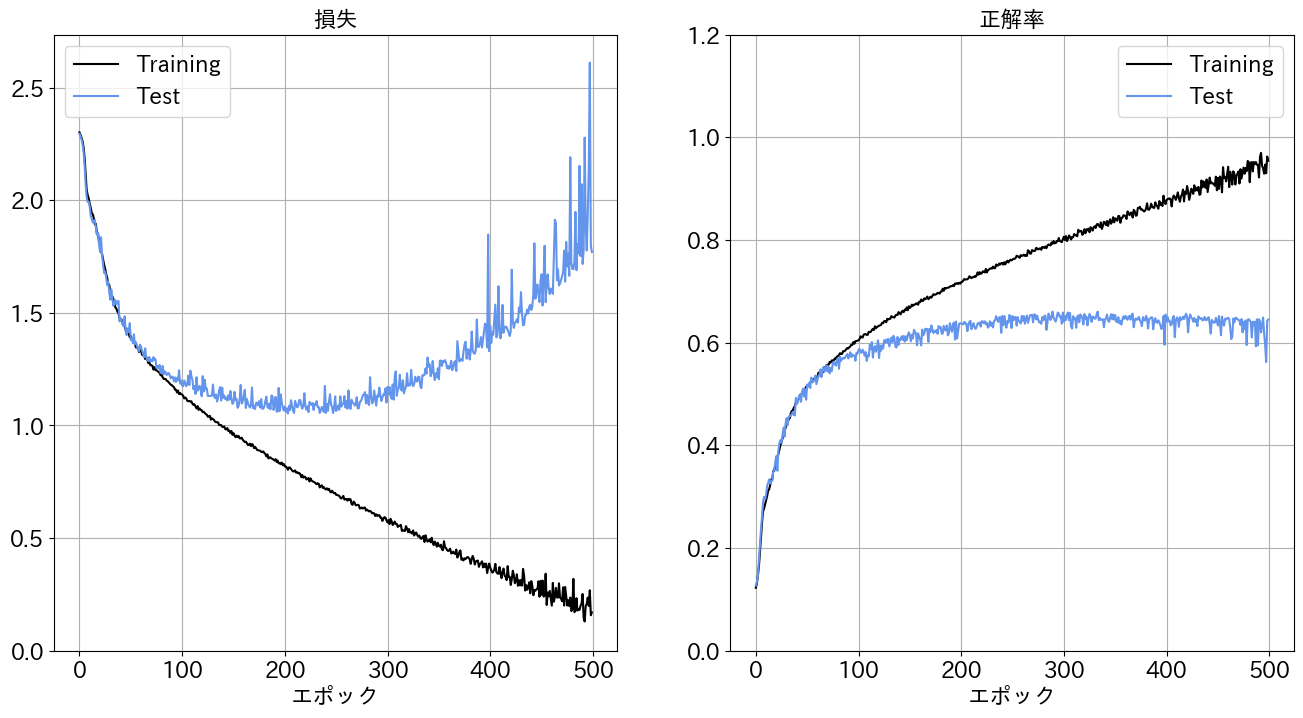

正解率
 0.65
精度
    0    1    2    3    4    5    6    7    8    9
 0.69 0.76 0.56 0.47 0.58 0.53 0.66 0.70 0.78 0.71
再現率
    0    1    2    3    4    5    6    7    8    9
 0.70 0.73 0.54 0.45 0.60 0.49 0.74 0.70 0.77 0.73


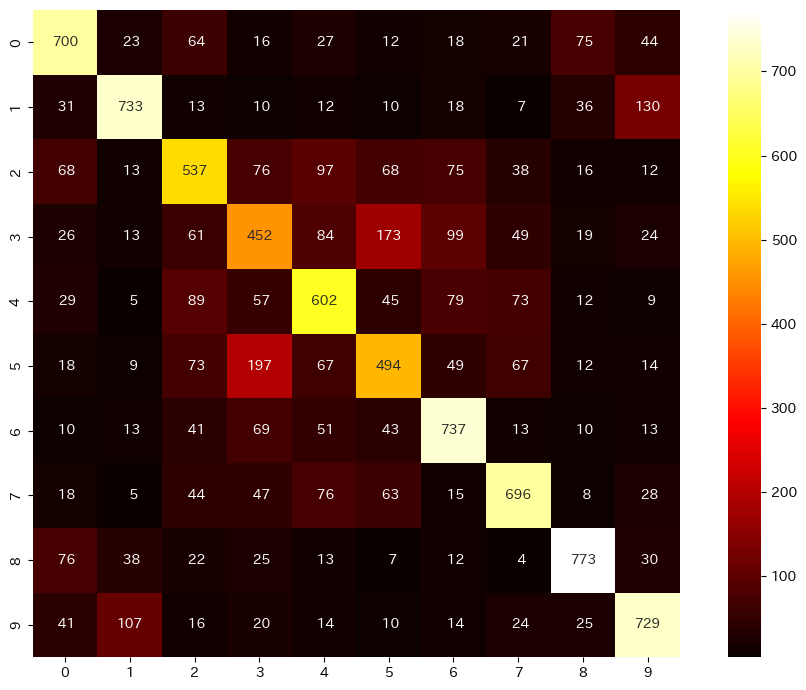

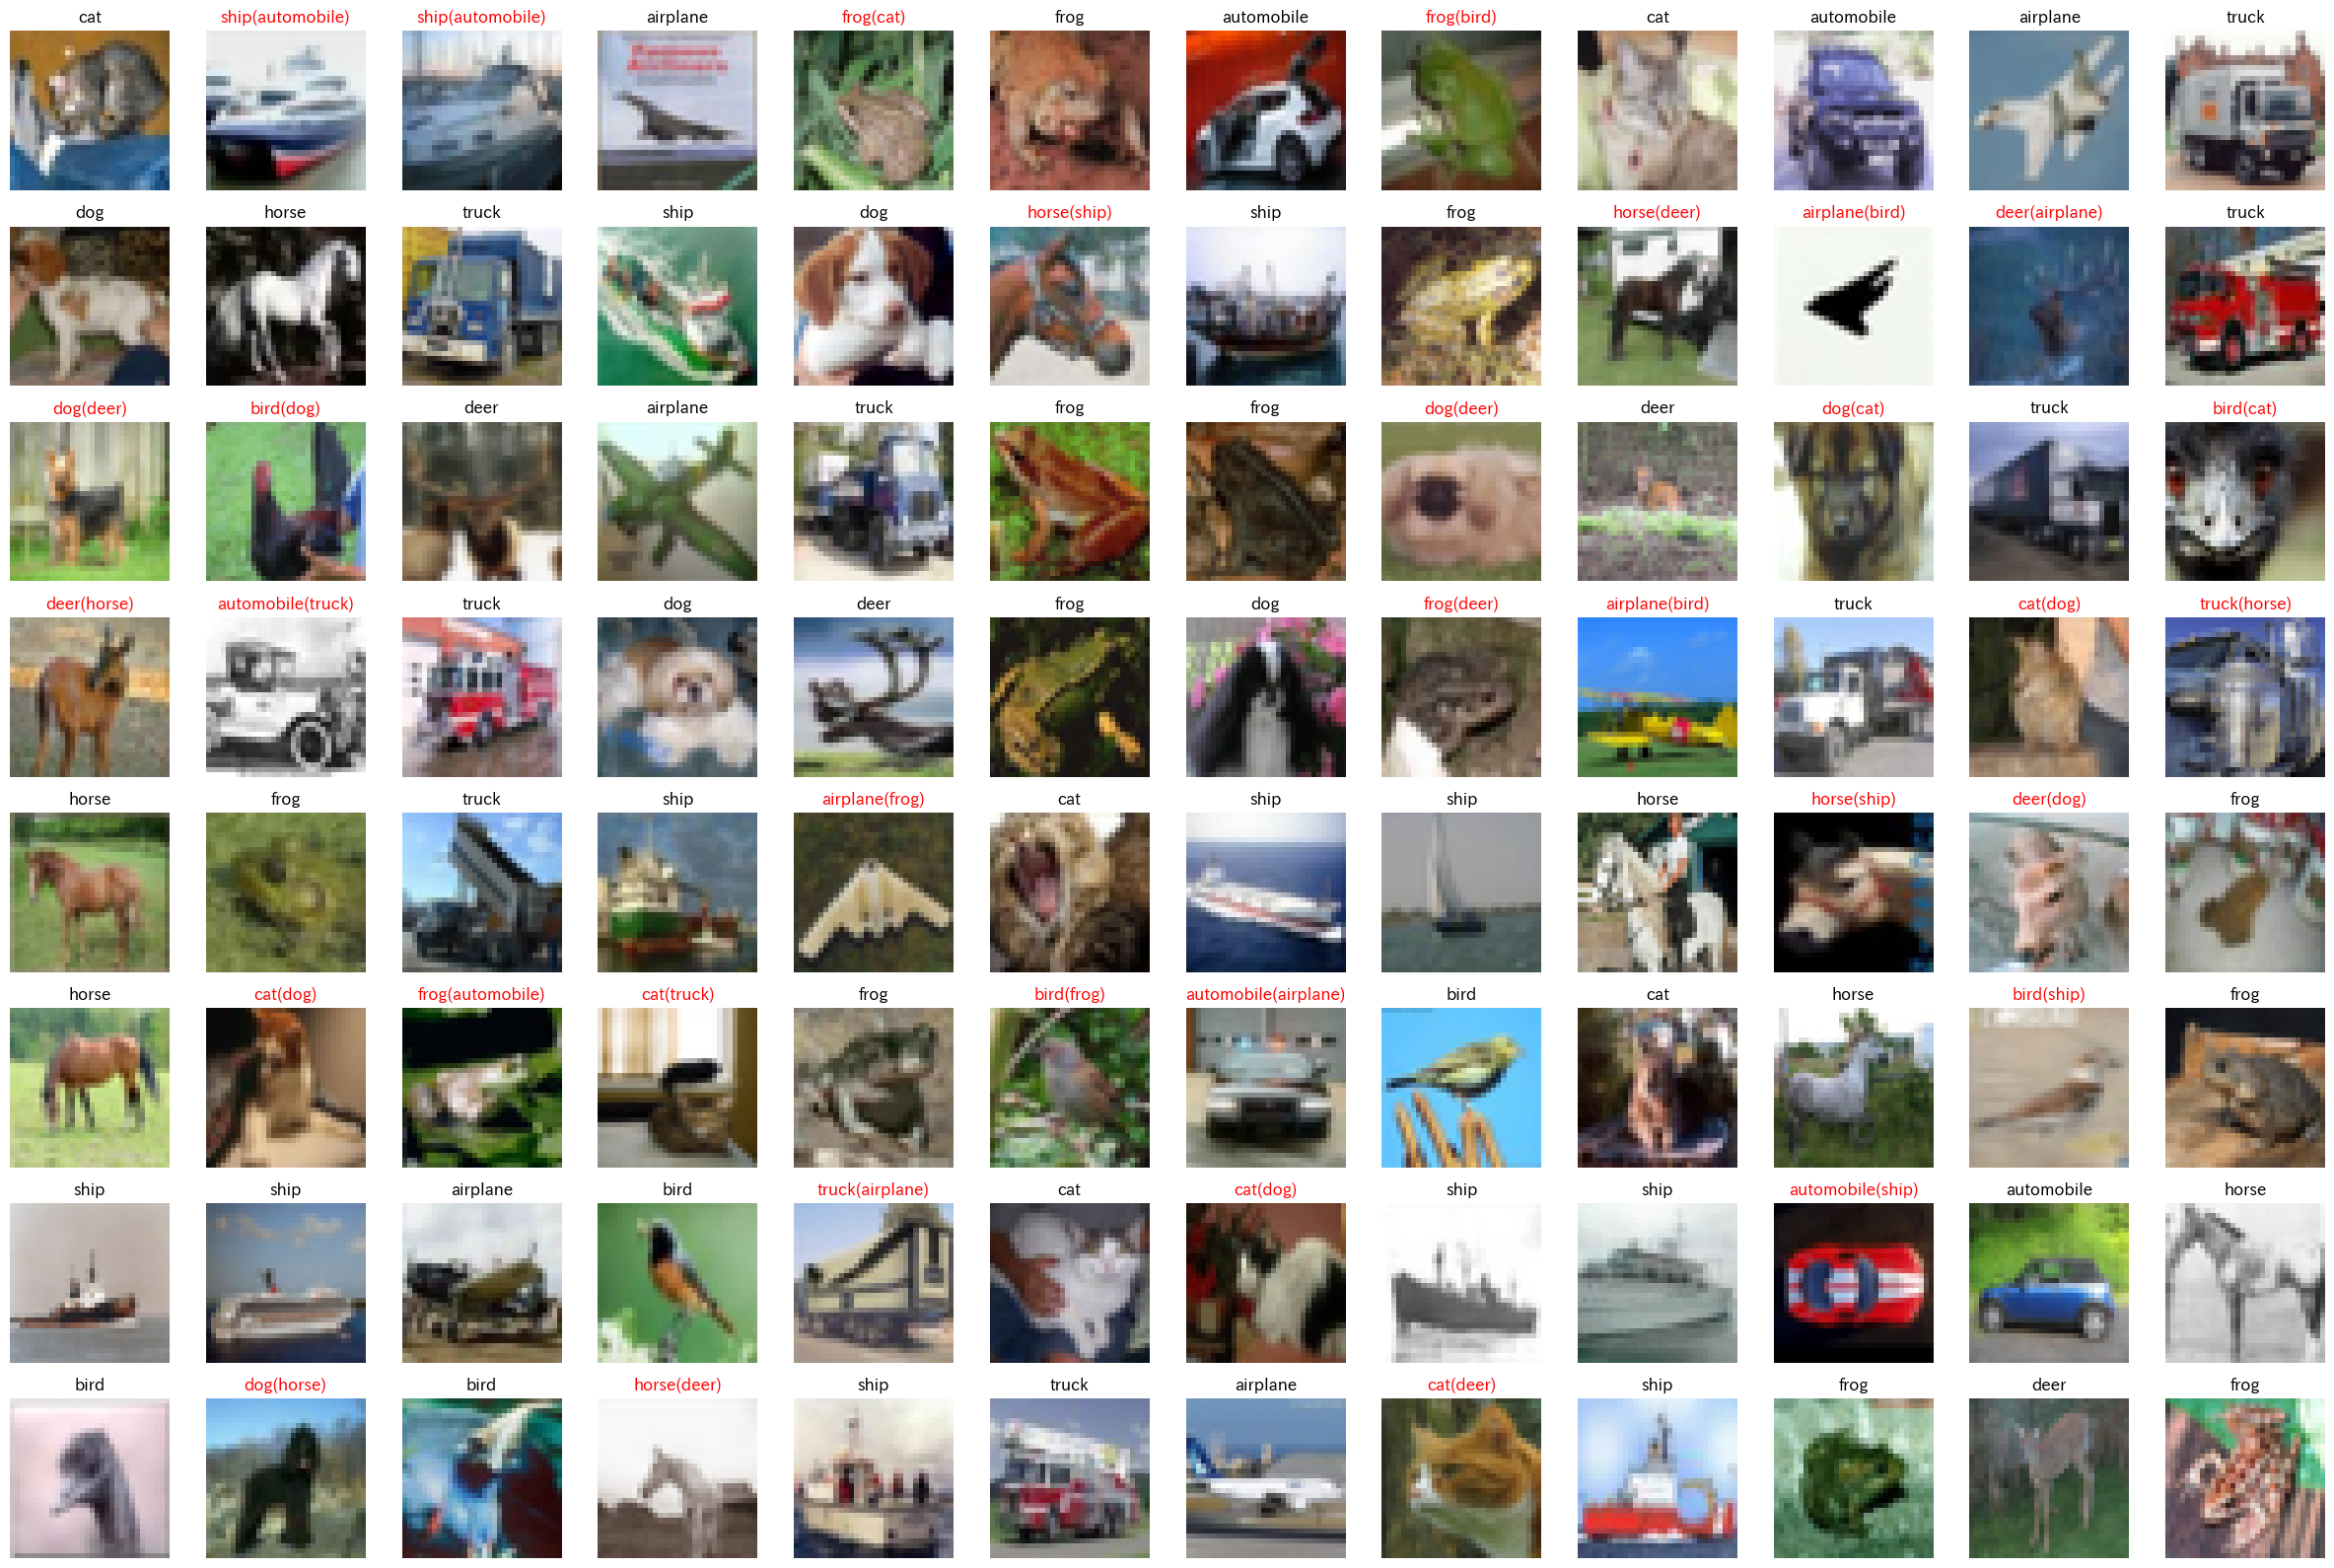

In [14]:
# 学習の履歴（損失と正解率の変化）を表示
show_history(history2)

# 学習したモデルを使い、テストデータのクラスラベルを予測
y_pred=model2.predict(x_test, verbose=0)

# 各データについて、最大の予測確率を持つクラスラベルを取得
y_pred=np.argmax(y_pred, axis=1)

# 正解（one-hotベクトル）をクラスラベルに戻す
y_true=np.argmax(y_test, axis=1)

# 混同行列、正解率、精度、再現率を評価
evaluate(x_test,y_true,y_pred)

# 予測結果の一部を可視化する
ids=range(96) # 可視化するデータの番号0から95

# データの番号0から95について、予測結果を可視化
show_prediction(x_test,y_true,y_pred,ids, dataset='cifar10',labels=labels)